<a href="https://colab.research.google.com/github/Ivanchukk/trading/blob/main/PyAlgoTrade_BuyHold_vs_MA200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install PyAlgoTrade yfinance pandas_market_calendars

In [13]:
import pandas
import pandas_market_calendars as market_calendar

from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns, drawdown, trades


In [3]:
data = yf.download("SPY", start="1988-01-01", end="2023-01-01")
data.to_csv("spy.csv")

[*********************100%***********************]  1 of 1 completed


2000-01-31 00:00:00 strategy [INFO] buying at 92.65471649169922, which is above 89.91049030303941
2000-02-01 00:00:00 strategy [INFO] ===== BUY at 92.77919174837167 10576 =====
2000-09-29 00:00:00 strategy [INFO] selling at 96.0599136352539, which is below 96.53012229919428
2000-10-02 00:00:00 strategy [INFO] ===== SELL at 96.49884855314724 =====
2002-03-28 00:00:00 strategy [INFO] buying at 78.03416442871094, which is above 77.53186336517325
2002-04-01 00:00:00 strategy [INFO] ===== BUY at 77.83656308927446 13052 =====
2002-04-30 00:00:00 strategy [INFO] selling at 73.49601745605469, which is below 76.76565673828121
2002-05-01 00:00:00 strategy [INFO] ===== SELL at 73.57096633452973 =====
2003-04-30 00:00:00 strategy [INFO] buying at 63.69460678100586, which is above 60.73825389862061
2003-05-01 00:00:00 strategy [INFO] ===== BUY at 63.701521915162346 15134 =====
2007-12-31 00:00:00 strategy [INFO] selling at 110.33772277832031, which is below 111.47633007049555
2008-01-02 00:00:00 st

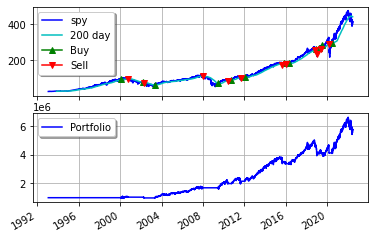

Final portfolio value: $5591932.96
Cumulative returns: 459.19 %
Max. drawdown: 22.44 %
Longest drawdown duration: 1253 days, 0:00:00

Total trades: 11
Avg. profit: $284816
Profits std. dev.: $565651
Max. profit: $1335023
Min. profit: $-546390
Avg. return: 17 %
Returns std. dev.: 28 %
Max. return: 74 %
Min. return: -12 %

Profitable trades: 7
Avg. profit: $557281
Profits std. dev.: $523885
Max. profit: $1335023
Min. profit: $39339
Avg. return: 30 %
Returns std. dev.: 27 %
Max. return: 74 %
Min. return:  1 %

Unprofitable trades: 4
Avg. loss: $-191999
Losses std. dev.: $205739
Max. loss: $-546390
Min. loss: $-55675
Avg. return: -5 %
Returns std. dev.:  4 %
Max. return: -1 %
Min. return: -12 %


In [14]:

# get last days of month
nyse = market_calendar.get_calendar('NYSE')
df = nyse.schedule(start_date='2000-01-01', end_date='2021-12-31')
df = df.groupby(df.index.strftime('%Y-%m')).tail(1)
df['date'] = pd.to_datetime(df['market_open']).dt.date
last_days_of_month = [date.isoformat() for date in df['date'].tolist()]

class MovingAverageStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(MovingAverageStrategy, self).__init__(feed)
        self.instrument = instrument
        self.position = None
        self.ma = ma.SMA(feed[instrument].getAdjCloseDataSeries(), 200)
        self.setUseAdjustedValues(True)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f"===== BUY at {execInfo.getPrice()} {execInfo.getQuantity()} =====")

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f"===== SELL at {execInfo.getPrice()} =====")
        self.position = None
    
    def onBars(self, bars):
        if self.ma[-1] is None:
            return

        bar = bars[self.instrument]
        close = bar.getAdjClose()
        date = bar.getDateTime().date().isoformat()

        if date in last_days_of_month:
            if self.position is None:
                broker = self.getBroker()
                cash = broker.getCash() * .98
                
                if date in last_days_of_month and close > self.ma[-1]:
                    quantity = cash / close
                    self.info(f"buying at {close}, which is above {self.ma[-1]}")
                    self.position = self.enterLong(self.instrument, quantity)
            
            elif close < self.ma[-1] and self.position is not None:
                self.info(f"selling at {close}, which is below {self.ma[-1]}")
                self.position.exitMarket()
                self.position = None


# # Load the bar feed from the CSV file
feed = yahoofeed.Feed()
feed.addBarsFromCSV("spy", "spy.csv")

strategy = MovingAverageStrategy(feed, "spy")

returnsAnalyzer = returns.Returns()
tradesAnalyzer = trades.Trades()
drawDownAnalyzer = drawdown.DrawDown()

strategy.attachAnalyzer(returnsAnalyzer)
strategy.attachAnalyzer(drawDownAnalyzer)
strategy.attachAnalyzer(tradesAnalyzer)

plt = plotter.StrategyPlotter(strategy) 
plt.getInstrumentSubplot("spy").addDataSeries("200 day", strategy.ma)

strategy.run()

plt.plot()

print("Final portfolio value: $%.2f" % strategy.getResult())
print("Cumulative returns: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100))
print("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

print("")
print("Total trades: %d" % (tradesAnalyzer.getCount()))
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getAllReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getPositiveReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print("Avg. loss: $%2.f" % (losses.mean()))
    print("Losses std. dev.: $%2.f" % (losses.std()))
    print("Max. loss: $%2.f" % (losses.min()))
    print("Min. loss: $%2.f" % (losses.max()))
    returns = tradesAnalyzer.getNegativeReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))
